In [5]:
import os
import sys
import argparse
import time
import datetime
import json
import random
import numpy as np
import torch

sys.path.append('..')
from bnp_options import *
from utils import *
from eval import *
from train import *
from env.toy_env import ToyEnv
from env.grid_env import GridEnv
from env.line_env import LineEnv
from env.roboturk_env import RoboturkEnv
from env.atari_env import AtariEnv

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
pretrained_dir = "../runs/atari_Sep23_10-23-12/"

In [80]:
with open(os.path.join(pretrained_dir, 'config.json'), 'r') as config_file:
    args = json.load(config_file)

In [82]:
# This will be used to generate the seeds for other RNGs.
random_seed = args['random_seed']
rng_master = np.random.RandomState(random_seed)
np.random.seed(random_seed) # there were some issue with reproducibility
random.seed(random_seed)
torch.manual_seed(random_seed)

env_seed = rng_master.randint(100000)
action_seed = rng_master.randint(100000)
split_seed = rng_master.randint(100000)
rng_env = np.random.RandomState(env_seed)
rng_split = np.random.RandomState(split_seed)

# Environment setup
demo_file = os.path.join('..', args['demo_file'])
max_steps = args['max_steps']
env_name = demo_file.split('/')[-2]
env_name = env_name[0].upper() + env_name[1:]
env = AtariEnv(f'{env_name}-ramNoFrameskip-v4', path=demo_file)
data = env.get_expert_trajectories(max_steps=max_steps)
train_data, test_data = split_train_test(data, rng_split)

Loading 1000 trajectories...


In [84]:
bnp_options = BNPOptions(train_data, env.state_dim, env.action_dim, device, rng=rng_master, **args)
bnp_options.load(os.path.join(pretrained_dir, 'checkpoint.pth'))

In [85]:
rollout = evaluate_options_usage(bnp_options, test_data, device)

In [86]:
list(rollout.keys())

['options',
 'relaxed_opts',
 'terminations',
 'relaxed_termins',
 'policies',
 'termin_funcs']

In [87]:
torch.argmax(rollout['relaxed_opts'], axis=-1)[0]

tensor([4, 1, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0,
        0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        1, 1, 2, 2, 2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 1, 0, 3, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 0, 0, 1, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 3, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 0, 2, 2,
        2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 3, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [88]:
(rollout['relaxed_termins'][0] > 0.9).nonzero()

tensor([[  1,   0],
        [  7,   0],
        [ 50,   0],
        [ 54,   0],
        [ 66,   0],
        [177,   0],
        [276,   0],
        [287,   0],
        [313,   0],
        [340,   0],
        [346,   0],
        [350,   0],
        [357,   0],
        [370,   0],
        [374,   0],
        [375,   0],
        [396,   0],
        [401,   0],
        [434,   0],
        [471,   0],
        [478,   0]], device='cuda:0')

In [89]:
(rollout['termin_funcs'][0] > 0.9).nonzero()

tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)

In [90]:
torch.argmax(rollout['policies'], axis=-1)[0]

tensor([4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2,
        4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 1, 4, 1, 1, 4, 1, 1, 5, 1, 1, 4,
        4, 5, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1, 1, 3, 4, 1, 1, 1, 2, 2, 2,
        4, 4, 4, 4, 1, 4, 1, 1, 1, 1, 4, 1, 4, 4, 2, 2, 4, 4, 4, 1, 4, 5, 4, 5,
        4, 5, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 1,
        1, 5, 5, 3, 1, 5, 5, 1, 1, 5, 5, 1, 3, 3, 3, 3, 1, 5, 5, 5, 1, 5, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
        5, 5, 5, 5, 5, 1, 5, 1, 0, 0, 0, 0, 4, 1, 1, 5, 0, 0, 4, 0, 0, 1, 1, 5,
        0, 1, 4, 4, 4, 2, 4, 1, 4, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 3, 5, 1, 1, 5, 4, 1, 1, 5, 1, 1, 1, 1, 4, 4, 2, 2, 2, 1, 4, 1, 1, 1,
        1, 1, 1, 1, 1, 3, 3, 5, 5, 4, 5, 1, 1, 1, 4, 4, 5, 4, 5, 4, 1, 1, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 4, 1, 1, 2, 2, 2, 4, 4, 1, 2, 4,
        2, 4, 1, 4, 1, 1, 5, 5, 5, 1, 5,

In [91]:
policies, termination = bnp_options.rollout_options(torch.tensor(test_data[0])[:, :-1].to(device))

In [100]:
aa = torch.exp(torch.distributions.OneHotCategorical(policies[0]).log_prob(torch.from_numpy(test_data[1])).unsqueeze(-1))[0]

In [101]:
bb = torch.exp(torch.distributions.OneHotCategorical(policies[1]).log_prob(torch.from_numpy(test_data[1])).unsqueeze(-1))[0]

In [102]:
cc = torch.exp(torch.distributions.OneHotCategorical(policies[2]).log_prob(torch.from_numpy(test_data[1])).unsqueeze(-1))[0]

In [103]:
for a, b, c, d in zip(aa, bb, cc, torch.argmax(rollout['relaxed_opts'], axis=-1)[0]):
    print(a, b, c, d)

tensor([0.9643]) tensor([0.9816]) tensor([0.9875]) tensor(4, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(1, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(1, device='cuda:0')
tensor([0.9290]) tensor([0.9555]) tensor([0.9372]) tensor(1, device='cuda:0')
tensor([0.9690]) tensor([0.9805]) tensor([0.9776]) tensor(4, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([0.9096]) tensor([0.9335]) tensor([0.9302]) tensor(0, device='cuda:0')
tensor([0.9839]) tensor([0.9930]) tensor([0.9947]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([0.7427]) tensor([0.7923]) tensor([0.7525]) tensor(0, device='cuda:0')
tensor([0.9416]) tensor([0.9586]) tensor([0.9380]) tensor(0, dev

tensor([0.9999]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([0.9944]) tensor([0.9939]) tensor([0.9904]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, dev

tensor([0.9948]) tensor([0.9982]) tensor([0.9991]) tensor(2, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(3, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(0, device='cuda:0')
tensor([0.9998]) tensor([1.0000]) tensor([0.9999]) tensor(2, device='cuda:0')
tensor([0.6772]) tensor([0.6892]) tensor([0.8539]) tensor(3, device='cuda:0')
tensor([0.9978]) tensor([0.9990]) tensor([0.9994]) tensor(2, device='cuda:0')
tensor([0.8639]) tensor([0.8873]) tensor([0.6386]) tensor(2, device='cuda:0')
tensor([0.9868]) tensor([0.9972]) tensor([0.9928]) tensor(2, device='cuda:0')
tensor([0.9821]) tensor([0.9893]) tensor([0.9824]) tensor(2, device='cuda:0')
tensor([0.9449]) tensor([0.9906]) tensor([0.9597]) tensor(2, device='cuda:0')
tensor([0.9732]) tensor([0.9733]) tensor([0.9822]) tensor(2, device='cuda:0')
tensor([0.9995]) tensor([0.9999]) tensor([0.9995]) tensor(2, device='cuda:0')
tensor([1.0000]) tensor([1.0000]) tensor([1.0000]) tensor(2, dev

In [105]:
count = [0]*18
for i in range(args['max_steps']-1):
    if torch.argmax(rollout['relaxed_opts'], axis=-1)[0][i] == 0:
        count[torch.argmax(rollout['policies'], axis=-1)[0][i]] += 1
print(count)

[3, 30, 15, 17, 25, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [110]:
count = [0]*env.env.action_space.n
for i in range(args['max_steps']-1):
    if torch.argmax(rollout['relaxed_opts'], axis=-1)[0][i] == 3:
        count[torch.argmax(rollout['policies'], axis=-1)[0][i]] += 1
print(count)

[11, 27, 15, 11, 10, 18]


In [111]:
env.env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [37]:
# images
# This will be used to generate the seeds for other RNGs.
random_seed = args['random_seed']
rng_master = np.random.RandomState(random_seed)
np.random.seed(random_seed) # there were some issue with reproducibility
random.seed(random_seed)
torch.manual_seed(random_seed)

env_seed = rng_master.randint(100000)
action_seed = rng_master.randint(100000)
split_seed = rng_master.randint(100000)
rng_env = np.random.RandomState(env_seed)
rng_split = np.random.RandomState(split_seed)

# Environment setup
images_file = "../datasets/atari/seaquest/trajectories_images.npy"
perm = rng_split.permutation(1000)
test_images = np.load(images_file, allow_pickle=True)[perm[:10]]

In [53]:
len(test_images)

10

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
%matplotlib notebook

<IPython.core.display.Javascript object>


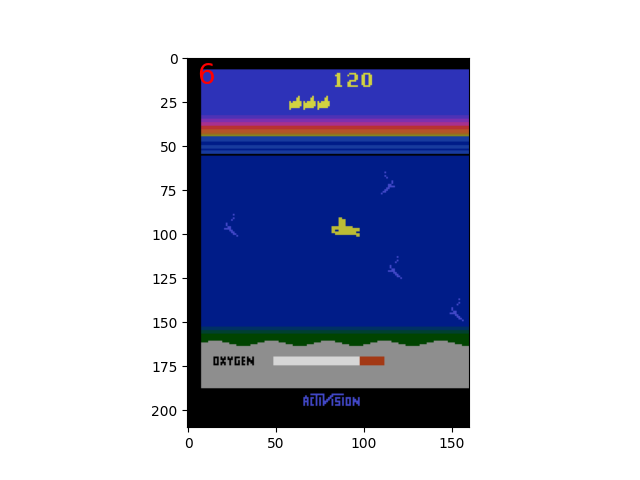

In [87]:
traj = 0

fig = plt.figure()
ax = plt.axes()
im = ax.imshow(test_images[traj][0][0])
label = ax.text(10, 10, "NA", ha='center', va='center', fontsize=20, color="Red")

def animate(n, *args, **kwargs):
    ax.imshow(test_images[traj][n][0])
    label.set_text(str(int(torch.argmax(rollout['relaxed_opts'], axis=-1)[0][n])))
    return

ani = animation.FuncAnimation(fig, animate, frames = 500, interval = 30, blit = False, repeat = False)
fig.show()


In [112]:
import gym
env = gym.make('SpaceInvadersNoFrameskip-v4')

In [121]:
obs = env.reset()
total_reward = 0
option = 2

In [122]:
trajectory = []
i = 0
done = False
while not done:
    action, termination = bnp_options.play_from_observation(option, np.unpackbits(env.unwrapped._get_ram()))
    obs, reward, done, info = env.step(action)
    frame = env.render(mode='rgb_array')
    trajectory.append(frame)
#     plt.imshow(frame)
    if termination > 0.1:
        print(i)
    i += 1
    total_reward += reward

In [123]:
len(trajectory)

2367

In [124]:
total_reward

160.0

<IPython.core.display.Javascript object>


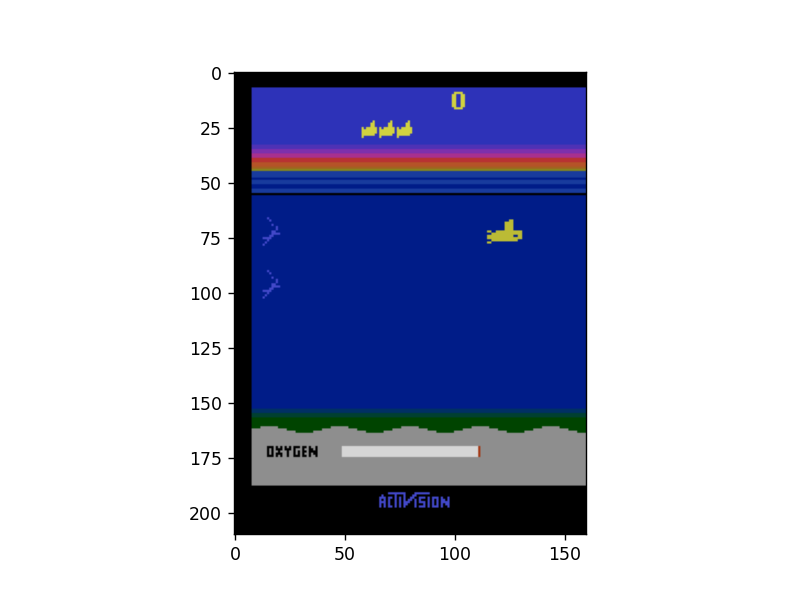

In [36]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(trajectory[100])

def animate(n, *args, **kwargs):
    ax.imshow(trajectory[100+n])
    return

ani = animation.FuncAnimation(fig, animate, frames = 100, interval = 5, blit = False, repeat = False)
fig.show()